# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
# -*- coding: utf-8 -*- 
# Run some setup code for this notebook.

import random
import numpy as np
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

from __future__ import print_function

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

In [2]:
train_data = CIFAR10('./CIFAR10',train=True,transform=transforms.ToTensor(),download=True)
test_data = CIFAR10('./CIFAR10',train=False,transform=transforms.ToTensor(),download=True)

X_train = train_data.data.astype('float')
y_train = np.array(train_data.targets)

X_test = test_data.data.astype('float')
y_test = np.array(test_data.targets)

print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)


Extracting ./CIFAR10/cifar-10-python.tar.gz to ./CIFAR10
Files already downloaded and verified
Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


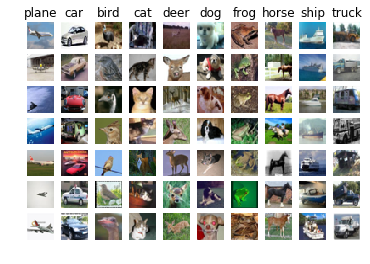

In [4]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7

for y,cls in enumerate(classes):
  idxs = np.flatnonzero(y_train==y)
  idxs = np.random.choice(idxs,samples_per_class,replace=False)

  for i,idx in enumerate(idxs):
    plt_idx = num_classes*i+y+1
    plt.subplot(samples_per_class,num_classes,plt_idx)
    plt.imshow(X_train[idx].astype('uint8'))
    plt.axis('off')

    if i==0:
      plt.title(cls)

plt.show()


In [5]:
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

mask = range(num_training, num_training+num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

mask = np.random.choice(num_training,num_dev,replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [6]:
X_train = X_train.reshape(X_train.shape[0],-1)
X_test = X_test.reshape(X_test.shape[0],-1)
X_dev = X_dev.reshape(X_dev.shape[0],-1)
X_val = X_val.reshape(X_val.shape[0],-1)

print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


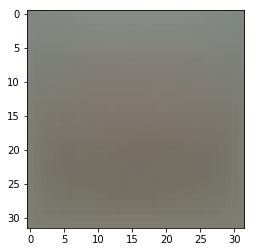

In [7]:
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10])
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape(32,32,3).astype('uint8'))
plt.show()

In [8]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [9]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


## SVM Classifier

Your code for this section will all be written inside **cs231n/classifiers/linear_svm.py**. 

As you can see, we have prefilled the function `compute_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [10]:
# Evaluate the naive implementation of the loss we provided for you:
from linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))
print(grad)

loss: 8.899138
[[-8.59646016e+00  1.34701523e+00  1.12525801e+01 ... -1.29465533e+01
  -2.67927699e+01 -2.23583259e+01]
 [-2.11638812e+01  9.15484918e+00  1.09708859e+01 ... -1.30683745e+01
  -4.07490594e+01 -2.57813241e+01]
 [-4.00769745e+01  5.32764498e+00  2.17991209e+01 ... -1.88303906e+01
  -6.27125127e+01 -3.19753231e+01]
 ...
 [-9.12998727e+00 -5.56692751e+00  6.09981045e+00 ... -1.60879453e+01
   2.41939936e+01 -7.92866155e+00]
 [-2.07283503e+01 -1.63853209e+01  7.71886772e+00 ... -3.83005571e+00
   4.04917514e+00 -1.09182903e+01]
 [ 1.16000001e-01 -2.81999998e-01  1.57999999e-01 ... -1.30000000e-01
  -5.79999997e-02  2.55999998e-01]]


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [12]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: -40.344783 analytic: -40.274813, relative error: 8.679054e-04
numerical: 11.296956 analytic: 11.296956, relative error: 2.756100e-11
numerical: -14.072078 analytic: -14.072078, relative error: 2.944631e-12
numerical: 9.132896 analytic: 9.132896, relative error: 1.005589e-11
numerical: -10.096374 analytic: -10.096374, relative error: 2.453458e-11
numerical: -1.105351 analytic: -1.132969, relative error: 1.233897e-02
numerical: 3.139901 analytic: 3.139901, relative error: 6.828560e-11
numerical: -6.092671 analytic: -6.092671, relative error: 1.415557e-11
numerical: 1.461849 analytic: 1.461849, relative error: 1.761796e-10
numerical: 28.534135 analytic: 28.469549, relative error: 1.133018e-03
numerical: -23.712180 analytic: -23.692508, relative error: 4.149792e-04
numerical: 3.420212 analytic: 3.420212, relative error: 6.171789e-11
numerical: -4.651836 analytic: -4.651836, relative error: 4.592285e-11
numerical: 2.640758 analytic: 2.551674, relative error: 1.715663e-02
numerica

### Inline Question 1:
It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? *Hint: the SVM loss function is not strictly speaking differentiable*

**Your Answer:** *힌지 loss function에서 margin이 0인 부분은 미분이 불가능하다. 따라서 임의의 값으로 계산한것이므로 오차가 발생 할 수 밖에 없다.
*


In [13]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

print('y : {}'.format(y_dev.shape))

Naive loss: 8.899138e+00 computed in 0.088363s
Vectorized loss: 8.899138e+00 computed in 0.008593s
difference: -0.000000
y : (500,)


In [14]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.089090s
Vectorized loss and gradient: computed in 0.006286s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [17]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from linear_classifier import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4, num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 797.982026
iteration 100 / 1500: loss 290.073938
iteration 200 / 1500: loss 108.598540
iteration 300 / 1500: loss 43.245891
iteration 400 / 1500: loss 19.026727
iteration 500 / 1500: loss 10.261828
iteration 600 / 1500: loss 7.684823
iteration 700 / 1500: loss 6.261313
iteration 800 / 1500: loss 5.423886
iteration 900 / 1500: loss 5.560865
iteration 1000 / 1500: loss 5.621695
iteration 1100 / 1500: loss 5.553535
iteration 1200 / 1500: loss 5.413858
iteration 1300 / 1500: loss 4.830579
iteration 1400 / 1500: loss 4.531717
That took 4.825739s


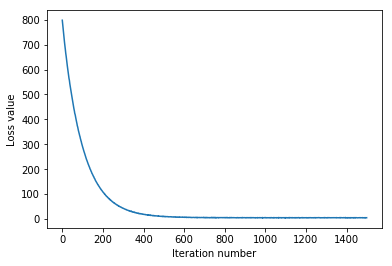

In [18]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [19]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.370347
validation accuracy: 0.388000


In [24]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.
learning_rates = [1e-7, 5e-5]
regularization_strengths = [2.5e4, 5e4]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################

for learning_rate in learning_rates:
  for reg in regularization_strengths:
    svm = LinearSVM()
    num_iters = 1500

    svm.train(X_train,y_train,batch_size=200, learning_rate=learning_rate, 
              reg=reg, verbose=True, num_iters=num_iters)
    y_pred = svm.predict(X_train)
    train_accuracy = np.mean(y_pred==y_train)

    y_pred = svm.predict(X_val)
    val_accuracy = np.mean(y_pred==y_val)

    results[(learning_rate,reg)] = (train_accuracy,val_accuracy)

    if best_val < val_accuracy:
      best_val = val_accuracy
      best_svm = svm

################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1500: loss 789.291193
iteration 100 / 1500: loss 289.120122
iteration 200 / 1500: loss 108.319451
iteration 300 / 1500: loss 42.833384
iteration 400 / 1500: loss 18.651445
iteration 500 / 1500: loss 10.299077
iteration 600 / 1500: loss 7.144553
iteration 700 / 1500: loss 6.233149
iteration 800 / 1500: loss 5.538061
iteration 900 / 1500: loss 5.281787
iteration 1000 / 1500: loss 4.851149
iteration 1100 / 1500: loss 5.074165
iteration 1200 / 1500: loss 4.828613
iteration 1300 / 1500: loss 5.698713
iteration 1400 / 1500: loss 5.258126
iteration 0 / 1500: loss 1565.968194
iteration 100 / 1500: loss 211.895806
iteration 200 / 1500: loss 33.208684
iteration 300 / 1500: loss 8.815535
iteration 400 / 1500: loss 5.822001
iteration 500 / 1500: loss 5.886071
iteration 600 / 1500: loss 5.699338
iteration 700 / 1500: loss 5.865415
iteration 800 / 1500: loss 5.960608
iteration 900 / 1500: loss 5.837839
iteration 1000 / 1500: loss 6.150051
iteration 1100 / 1500: loss 5.532721
iteration 

linear_svm.py:97: RuntimeWarning: overflow encountered in double_scalars
  loss += reg * np.sum(W * W) # l2정규화
/usr/local/lib/python2.7/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
linear_svm.py:97: RuntimeWarning: overflow encountered in multiply
  loss += reg * np.sum(W * W) # l2정규화


iteration 900 / 1500: loss inf
iteration 1000 / 1500: loss inf
iteration 1100 / 1500: loss inf
iteration 1200 / 1500: loss inf
iteration 1300 / 1500: loss inf
iteration 1400 / 1500: loss inf
iteration 0 / 1500: loss 1548.646549
iteration 100 / 1500: loss 4193034266030553085752994631398409938299383628713981176680817826611659376918005380123948631394687104363724647895401806954496.000000
iteration 200 / 1500: loss 10827462222271625944397851488590604797485565235536645949751337204498329732613307686259733747322211878612894816548017881067294039237285411582358468802816884555373182132499731908592717056792182069715996789105237012910211732090960658143028493418496.000000
iteration 300 / 1500: loss inf
iteration 400 / 1500: loss inf
iteration 500 / 1500: loss inf


linear_svm.py:120: RuntimeWarning: overflow encountered in multiply
  dW = dW + reg * 2 * W
linear_svm.py:113: RuntimeWarning: invalid value encountered in greater
  margin[margin>0] = 1


iteration 600 / 1500: loss nan
iteration 700 / 1500: loss nan
iteration 800 / 1500: loss nan
iteration 900 / 1500: loss nan
iteration 1000 / 1500: loss nan
iteration 1100 / 1500: loss nan
iteration 1200 / 1500: loss nan
iteration 1300 / 1500: loss nan
iteration 1400 / 1500: loss nan
lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.370755 val accuracy: 0.370000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.349592 val accuracy: 0.354000
lr 5.000000e-05 reg 2.500000e+04 train accuracy: 0.048755 val accuracy: 0.048000
lr 5.000000e-05 reg 5.000000e+04 train accuracy: 0.100265 val accuracy: 0.087000
best validation accuracy achieved during cross-validation: 0.370000


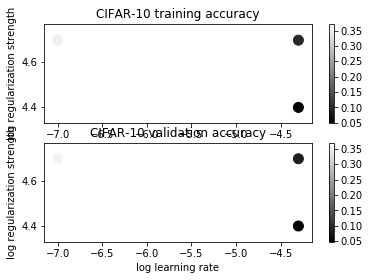

In [25]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [26]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.365000


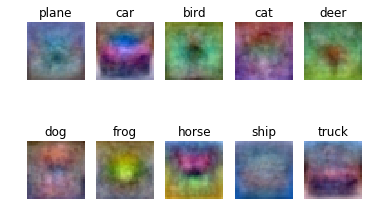

In [27]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

### Inline question 2:
Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do.

**Your answer:** 같은 카테고리의 여러개 사진을 하나로 합친것처럼 보인다. 예를 들면 horse같은경우 머리가 양쪽으로 있는것처럼 보인다. 아무래도 같은 물체의 이미지라해도 각도가 다르기 때문에 이런 형태로 보이는것 같다.